In [1]:
%reload_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


# TODO

In [2]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import optax

from markovsbi.tasks import KolmogorovFlow
from markovsbi.utils.utils_plot import draw, vorticity
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn, build_online_batch_sampler

In [3]:
jax.devices()

[cuda(id=0)]

In [4]:
key = jax.random.PRNGKey(0)

2024-09-30 10:35:15.625270: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
task = KolmogorovFlow(64, sigma=5e-3)
prior = task.get_prior()
simulator = task.get_simulator()

In [6]:
T = 2

In [7]:
data = task.get_data(key, 500, T, init_T=0)
sde, weight_fn = init_sde(data)

In [8]:
data["xs"].shape

(500, 2, 2, 64, 64)

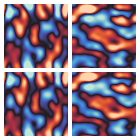

In [9]:

draw(data["xs"][6], zoom=.5)

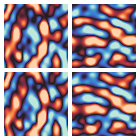

In [10]:

draw(data["xs"][1], zoom=.5)

In [11]:
sde, weight_fn = init_sde(data, beta_max=20.)

In [12]:
sde.mu(1.)

Array(0.007, dtype=float32, weak_type=True)

In [13]:
key, key_init = jax.random.split(key)

In [14]:
import haiku as hk

def embedding_net(x):
    x = x.astype(jnp.float32)

    if x.ndim < 5:
        x = x[None]
        squeeze = True
    else:
        squeeze = False
    shape = x.shape
    x = x.transpose((0, 1, 3, 4, 2))
    x = x.reshape((-1, 64, 64, 2))

    h1 = hk.Conv2D(64, kernel_shape=6, stride=2, padding='VALID')(x)
    h1 = hk.GroupNorm(4)(h1)
    h1 = jax.nn.gelu(h1)
    #print(h1.shape)
    h2 = hk.Conv2D(32, kernel_shape=6, stride=2, padding='VALID')(h1)
    h2 = hk.GroupNorm(4)(h2)
    h2 = jax.nn.gelu(h2)
    #print(h2.shape)
    h3 = hk.Conv2D(16, kernel_shape=3, stride=1, padding='VALID')(h2)
    h3 = hk.GroupNorm(4)(h3)
    h3 = jax.nn.gelu(h3)
    #print(h3.shape)
    h4 = hk.Conv2D(8, kernel_shape=3, stride=1, padding='VALID')(h3)
    #print(h4.shape)
    h6 = hk.Flatten()(h4)
    out = hk.Linear(100)(h6)
    out = jax.nn.gelu(out)
    out = hk.Linear(100)(out)
    #print(out.shape)
    out = out.reshape(shape[:2] + (100,))
    out = jax.nn.gelu(out)
    #print(out.shape)
    if squeeze:
        out = out[0]
    return out


In [15]:
c_in, c_noise, c_out = precondition_functions(sde)
init_fn, score_net = build_score_mlp(T, num_hidden=5,hidden_dim=400, c_in=c_in, c_noise=c_noise, c_out=c_out, c_context=embedding_net)
batch_sampler = build_batch_sampler(data)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn,control_variate=True, control_variate_optimal_scaling=True)

In [16]:
theta_batch, x_batch = batch_sampler(key_init, 50)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape)

(50, 2) (50, 2, 2, 64, 64)


We skip training (thats done via the `train.py` script) and only do the inference here.

In [17]:
# params = init_fn(key_init, jnp.ones((50,)), theta_batch, x_batch)

In [ ]:
# loss_fn(params, key,theta_batch, x_batch)

(100, 30, 30, 64)
(100, 13, 13, 32)
(100, 11, 11, 16)
(100, 9, 9, 8)
(100, 150)
(50, 2, 150)
(100, 30, 30, 64)
(100, 13, 13, 32)
(100, 11, 11, 16)
(100, 9, 9, 8)
(100, 150)
(50, 2, 150)


Array(14.738, dtype=float32)

In [ ]:

# schedule = optax.cosine_onecycle_schedule (
#     50*5000, 5e-4,
# )
# optimizer = optax.chain(optax.adaptive_grad_clip(20.), optax.adamw(schedule))
# opt_state = optimizer.init(params)

In [ ]:
#  50*2000

100000

In [ ]:
# loss_fn = jax.jit(loss_fn)

# @jax.jit
# def update(params, rng, opt_state, theta_batch, x_batch):
#     loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch)
#     updates, opt_state = optimizer.update(grads, opt_state, params=params)
#     params = optax.apply_updates(params, updates)
#     return loss, params, opt_state

In [ ]:
# def move_to_cpu(x):
#     return jax.device_put(x, jax.devices("cpu")[0])

In [288]:
# data = jax.tree_util.tree_map(move_to_cpu, dict(jnp.load(f"data_fnpe_noisy/data{0}.npy", allow_pickle=True).item()))
# for i in range(1,20):
#     data_new =jax.tree_util.tree_map(move_to_cpu,  dict(jnp.load(f"data_fnpe_noisy/data{i}.npy", allow_pickle=True).item()))
#     data["thetas"] = jnp.concatenate([data["thetas"], data_new["thetas"]])
#     data["xs"] = jnp.concatenate([data["xs"], data_new["xs"]])

In [289]:
# # Shuffle each array in the dictionary
# import numpy as np
# data = {k: jax.random.permutation(jax.random.key(0), v) for k, v in data.items()}
# data_val = {k: v[-5000:] for k, v in data.items()}
# data_train = {k: np.array(v[:-5000]) for k,v in data.items()}

In [290]:
# batch_sampler_val = build_batch_sampler(data_val)
# batch_sampler = build_batch_sampler(data_train, jit=False)

In [291]:
# thetas_train = data_train["thetas"]
# xs_train = data_train["xs"]

In [292]:
# def batch_sampler(thetas_train, xs_train):
#     idx = np.random.randint(0, xs_train.shape[0], size=500)
#     theta_batch = thetas_train[idx]
#     xs_train = xs_train[idx]
#     return theta_batch, xs_train

In [293]:
# np.random.seed(0)

In [294]:

# best_loss = jnp.inf
# best_params = None

# for i in range(50):
#     l = 0.
#     for _ in range(5000):
#         key, key_batch, key_loss = jax.random.split(key,3)
#         theta_batch, x_batch = batch_sampler(thetas_train, xs_train)
#         theta_batch = jax.device_put(theta_batch)
#         x_batch = jax.device_put(x_batch)
#         loss, params, opt_state = update(params, key_loss, opt_state, theta_batch, x_batch)
#         l += loss/5000
#     l_val = 0.
#     for _ in range(100):
#         key, key_batch, key_loss = jax.random.split(key,3)
#         theta_batch, x_batch = batch_sampler_val(key_batch, 500)
#         theta_batch = jax.device_put(theta_batch)
#         x_batch = jax.device_put(x_batch)
#         loss = loss_fn(params, key_loss, theta_batch, x_batch)
#         l_val += loss/100

#     print("Training loss: ", l)
#     print("Validation loss: ", l_val)

#     if l_val < best_loss:
#         best_loss = l_val
#         best_params = params.copy()


(1000, 30, 30, 64)
(1000, 13, 13, 32)
(1000, 11, 11, 16)
(1000, 9, 9, 8)
(1000, 150)
(500, 2, 150)
(1000, 30, 30, 64)
(1000, 13, 13, 32)
(1000, 11, 11, 16)
(1000, 9, 9, 8)
(1000, 150)
(500, 2, 150)
Training loss:  12.433287
Validation loss:  11.875848
Training loss:  11.593611
Validation loss:  11.328837
Training loss:  11.378798
Validation loss:  11.213338
Training loss:  11.386767
Validation loss:  12.081648
Training loss:  11.374538
Validation loss:  11.885442
Training loss:  11.27138
Validation loss:  11.316092
Training loss:  11.270167
Validation loss:  10.879571
Training loss:  11.091595
Validation loss:  11.3032
Training loss:  11.093029
Validation loss:  11.57838
Training loss:  11.044355
Validation loss:  11.347363
Training loss:  10.9638405
Validation loss:  10.356782
Training loss:  10.879728
Validation loss:  10.410818
Training loss:  10.875682
Validation loss:  10.609747
Training loss:  10.762262
Validation loss:  10.965419
Training loss:  10.795794
Validation loss:  12.11

In [18]:
params = jnp.load("params_fnse.npy", allow_pickle=True).item()

In [19]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn

In [223]:
key = jax.random.PRNGKey(6)
theta_o = prior.sample(key)
num_obs = 101
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

[0.968 0.297]


In [224]:
num_obs

101

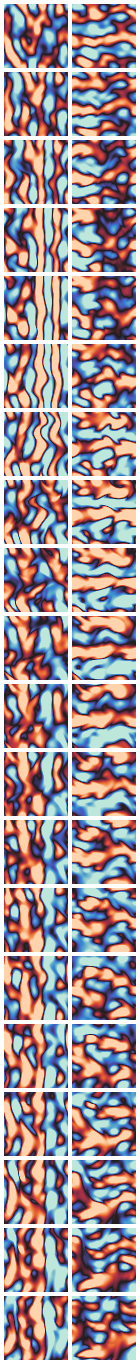

In [225]:
draw(x_o[1::5], zoom=1)

In [106]:
x_o.shape

(101, 2, 64, 64)

In [107]:
fig = plt.figure(figsize=(5,1.5))
# plt.plot(x_o)
# plt.savefig("obs.png")

<Figure size 500x150 with 0 Axes>

In [108]:
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)

In [109]:
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
score_fn.estimate_hyperparameters(key, theta_o.shape, x_o, diag=False, precission_nugget=0.1)

In [110]:
import haiku as hk

In [111]:

from markovsbi.sampling.sample import Diffuser
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM
from markovsbi.models.utils import get_windows
d = 2
kernel = EulerMaruyama(score_fn)
length = 4000
time_grid = jnp.linspace(sde.T_min + 0.01, sde.T_max, length)
sampler = Diffuser(kernel, time_grid, (d,))


In [112]:
traces = jax.vmap(sampler.simulate, in_axes=(0,None))(jax.random.split(key,(100,)), x_o)

(-5.0, 5.0)

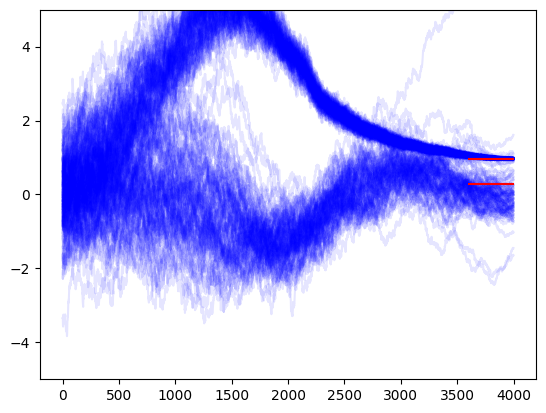

In [113]:
# ???
for t in traces:
    plt.plot(t, alpha=0.1, color="blue")
plt.hlines(theta_o, length-length/10, length, color="red")
plt.ylim(-5,5)

In [114]:
samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 1000), x_o)

In [115]:
samples.std(0)

Array([0.02 , 0.596], dtype=float32)

Text(0, 0.5, '$\\theta_2$')

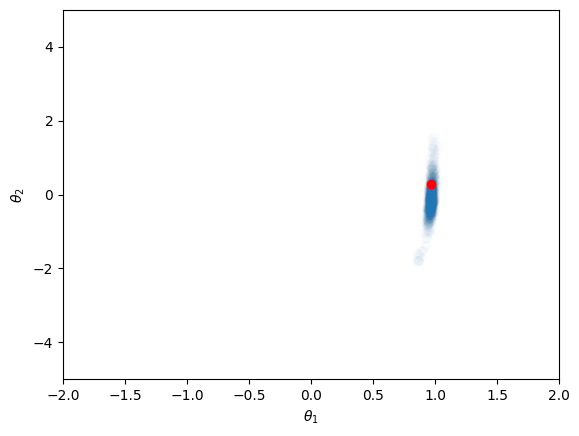

In [116]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.01)
plt.scatter(theta_o[0], theta_o[1], color="red")
plt.ylim(-5,5)
plt.xlim(-2,2)
plt.xlabel(r"$\theta_1$")

plt.ylabel(r"$\theta_2$")

In [117]:
from markovsbi.bm.plot_utils import use_style

In [118]:
x_o_vorticity = jax.vmap(vorticity)(x_o)

In [119]:
x_o_vorticity.shape

(101, 64, 64)

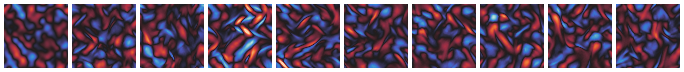

In [120]:
img = draw(x_o_vorticity[::11], zoom=-2)

img

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


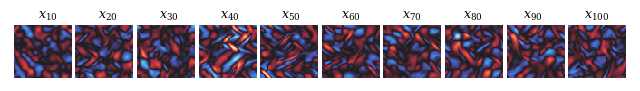

In [121]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(8,1))
    plt.imshow(img, aspect=0.9)
    plt.axis("off")
    for i in range(10):
        plt.text(30 + 67*i,-5,r"$x_{" + str(i*10 + 10) + r"}$")
    fig.savefig("x_o_kolmogorov.svg")

In [226]:
num_obs = 11

In [227]:
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
score_fn.estimate_hyperparameters(key, theta_o.shape, x_o[:num_obs], diag=False, precission_nugget=0.0)

In [228]:

kernel = EulerMaruyama(score_fn)
length = 4000
time_grid = jnp.linspace(sde.T_min, sde.T_max, length)
sampler = Diffuser(kernel, time_grid, (d,))


In [229]:
samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 10_000), x_o[:num_obs])

In [230]:
import seaborn as sns

In [231]:
color = "#f2a900"

In [232]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Define the target color (e.g., blue)
target_color = [118/255,181/255,197/255]  # RGB for blue

# Create a colormap from white to the target color
colors = [(1, 1, 1), target_color]  # White to target color
cmap_name = 'white_to_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

In [241]:
samples.min(-1).argsort()[1000:]

Array([  59, 7648, 8875, ..., 2434, 8061, 7270], dtype=int32)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

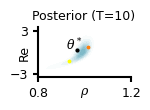

In [242]:
id1 = 0
id2 = 59
with use_style("pyloric"):
    fig = plt.figure(figsize=(1.2,0.65))
    sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, cmap=cmap, alpha=0.99)
    plt.scatter(theta_o[0], theta_o[1], color="black", s=4)
    plt.text(theta_o[0]-0.05, theta_o[1], r"$\theta^*$")
    plt.scatter(samples[id1,0], samples[id1,1], color="C1", s=3)
    plt.scatter(samples[id2,0], samples[id2,1], color="yellow", s=3)
    plt.ylim(-3.5,3.5)
    plt.yticks([-3,3])
    # plt.xlim(0, 2)
    # plt.xticks([0,2],labels=[])
    plt.ylabel(r"Re",labelpad=-15)
    plt.xlim(0.8, 1.2)
    plt.xticks([0.8,1.2])
    plt.xlabel(r"$\rho$", labelpad=-10)
    fig.suptitle("Posterior (T=10)", y=1.15)
    fig.savefig("posterior_t5", transparent=True)


In [259]:
key = jax.random.PRNGKey(0)
theta_pred = samples[id1]
num_obs = 101
x_pred = simulator(key, theta_pred, num_obs, x0=x_o[0])

In [260]:
num_obs

101

In [261]:
x_pred_vorticity = jax.vmap(vorticity)(x_pred)

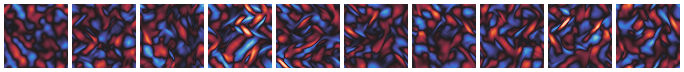

In [262]:
img2 = draw(x_pred_vorticity[::11])
img2

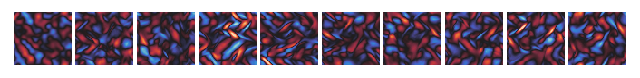

In [263]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(8,1))
    plt.imshow(img2,aspect=0.9)
    plt.axis("off")
    # for i in range(8):
    #     plt.text(30 + 67*i,80.,r"$x_{" + str(i*10 + 10) + r"}$")
    fig.savefig("x_pred1_kolmogorov.svg", transparent=True)

In [264]:
key = jax.random.PRNGKey(42)
theta_pred = samples[id2]
num_obs = 101
x_pred = simulator(key+1, theta_pred, num_obs, x0=x_o[0])

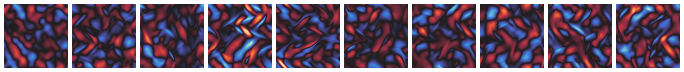

In [257]:
x_pred_vorticity = jax.vmap(vorticity)(x_pred)

img2_2 = draw(x_pred_vorticity[::11])
img2_2

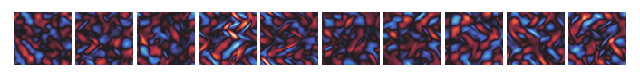

In [258]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(8,1))
    plt.imshow(img2_2,aspect=0.9)
    plt.axis("off")
    # for i in range(8):
    #     plt.text(30 + 67*i,80.,r"$x_{" + str(i*10 + 10) + r"}$")
    fig.savefig("x_pred1_2_kolmogorov.svg", transparent=True)

In [246]:
num_obs = 101

In [166]:
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
score_fn.estimate_hyperparameters(key, theta_o.shape, x_o[:num_obs], diag=False, precission_nugget=0.1)

In [167]:

kernel = EulerMaruyama(score_fn)
length = 4000
time_grid = jnp.linspace(sde.T_min, sde.T_max, length)
sampler = Diffuser(kernel, time_grid, (d,))


In [168]:
samples = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 10_000), x_o[:num_obs])

In [181]:
jnp.abs(samples-theta_o).sum(-1).argsort()[50:]

Array([6322, 2401, 4882, ..., 8626, 3952, 6559], dtype=int32)

In [170]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Define the target color (e.g., blue)
target_color = [118/255,181/255,197/255]  # RGB for blue

# Create a colormap from white to the target color
colors = [(1, 1, 1), target_color]  # White to target color
cmap_name = 'white_to_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

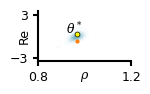

In [184]:
id1 = 2
id2 = 2401
with use_style("pyloric"):
    fig = plt.figure(figsize=(1.2,0.65))
    sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, cmap=cmap, alpha=0.99)
    plt.scatter(theta_o[0], theta_o[1], color="black")
    plt.text(theta_o[0]-0.05, theta_o[1], r"$\theta^*$")
    plt.scatter(samples[id1,0], samples[id1,1], color="C1", s=4.)
    plt.scatter(samples[id2,0], samples[id2,1], color="yellow", s=4.)
    plt.ylim(-3.5,3.5)
    plt.yticks([-3,3])
    plt.xlim(0.8, 1.2)
    plt.xticks([0.8,1.2])
    plt.xlabel(r"$\rho$", labelpad=-10)
    plt.ylabel(r"Re",labelpad=-15)
    #fig.suptitle("Posterior (T=100)", y=1.15)
    fig.savefig("posterior_t100")


In [185]:
key = jax.random.PRNGKey(1)
theta_pred = samples[id1]
num_obs = 5 + 4*24
x_pred = simulator(key, theta_pred, num_obs, x0=x_o[0])

In [186]:
x_pred_vorticity = jax.vmap(vorticity)(x_pred)

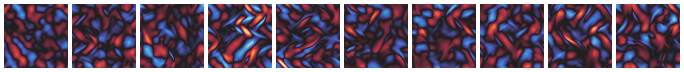

In [187]:
img3 = draw(x_pred_vorticity[::11])
img3

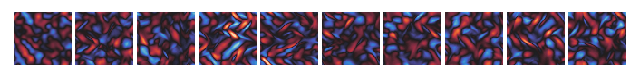

In [188]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(8,1))
    plt.imshow(img3, aspect=0.9)
    plt.axis("off")
    # for i in range(8):
    #     plt.text(30 + 67*i,80.,r"$x_{" + str(i*10 + 10) + r"}$")
    fig.savefig("x_pred2_kolmogorov.svg", transparent=True)

In [189]:
key = jax.random.PRNGKey(43)
theta_pred = samples[id2]
num_obs = 5 + 4*24
x_pred = simulator(key, theta_pred, num_obs, x0=x_o[0])

x_pred_vorticity = jax.vmap(vorticity)(x_pred)

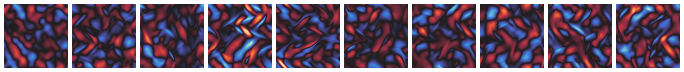

In [252]:
img3_2 = draw(x_pred_vorticity[::11])
img3_2

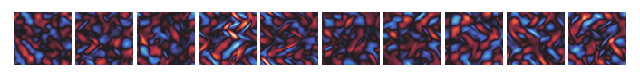

In [253]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(8,1))
    plt.imshow(img3_2, aspect=0.9)
    plt.axis("off")
    fig.savefig("x_pred2_2_kolmogorov.svg", transparent=True)

In [193]:
distances_2 = []

for i in range(50):
    key = jax.random.PRNGKey(i)
    theta_o = prior.sample(key)
    num_obs = 11
    x_o = simulator(key, theta_o, num_obs)

    score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
    score_fn.estimate_hyperparameters(key, theta_o.shape, x_o, diag=False, precission_nugget=0.0)


    kernel = EulerMaruyama(score_fn)
    length = 4000
    time_grid = jnp.linspace(sde.T_min, sde.T_max, length)
    sampler = Diffuser(kernel, time_grid, (d,))
    key1, key2 = jax.random.split(key)
    keys1 = jax.random.split(key1, (1000,))
    samples = jax.vmap(sampler.sample, in_axes=(0, None))(keys1, x_o[:num_obs])
    keys2 = jax.random.split(key2, (1000,))
    x_pred = jax.vmap(lambda k,x: simulator(k, x, num_obs, x0=x_o[0]))(keys2,samples)

    dist = float(jnp.abs(x_pred - x_o).sum(axis=-1).sum(axis=-1).sum(axis=-1).mean())

    distances_2.append(dist)


In [194]:
prior_distances2 = []
for i in range(50):
    key = jax.random.PRNGKey(i)
    theta_o = prior.sample(key)
    num_obs = 11
    x_o = simulator(key, theta_o, num_obs)

    key1, key2 = jax.random.split(key)
    keys1 = jax.random.split(key1, (1000,))
    samples = jax.vmap(prior.sample)(keys1)
    keys2 = jax.random.split(key2, (1000,))
    x_pred = jax.vmap(lambda k,x: simulator(k, x, num_obs, x0=x_o[0]))(keys2,samples)

    dist = float(jnp.abs(x_pred - x_o).sum(axis=-1).sum(axis=-1).sum(axis=-1).mean())

    prior_distances2.append(dist)


In [195]:
import pandas as pd
metrics = {"prior pred.": prior_distances2, "post. pred.": distances_2}

metrics = {
    'Set': ['prior'] * len(prior_distances2) + ['post.'] * len(distances_2),
    'Values': prior_distances2 + distances_2
}
df = pd.DataFrame(metrics)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


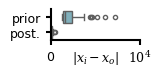

In [202]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(1.15,0.4))
    sns.boxplot(y='Set', x='Values', data=df, color="#76b5c5")
    plt.ylabel("")
    plt.xlim(0, 1000)
    plt.xticks([0,10000],["0", r"$10^4$"])
    #plt.xscale("log")
    plt.xlabel("$|x_i - x_o|$", labelpad=-12)
    fig.savefig("posterior_predictive_metric.svg", transparent=True)

In [198]:
distances_100 = []

for i in range(50):
    key = jax.random.PRNGKey(i)
    theta_o = prior.sample(key)
    num_obs = 101
    x_o = simulator(key, theta_o, num_obs)

    score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior)
    score_fn.estimate_hyperparameters(key, theta_o.shape, x_o, diag=False, precission_nugget=0.0)


    kernel = EulerMaruyama(score_fn)
    length = 4000
    time_grid = jnp.linspace(sde.T_min + 0.05, sde.T_max, length)
    sampler = Diffuser(kernel, time_grid, (d,))
    key1, key2 = jax.random.split(key)
    keys1 = jax.random.split(key1, (1000,))
    samples = jax.vmap(sampler.sample, in_axes=(0, None))(keys1, x_o[:num_obs])
    keys2 = jax.random.split(key2, (1000,))
    x_pred = jax.vmap(lambda k,x: simulator(k, x, num_obs, x0=x_o[0]))(keys2,samples)

    dist = float(jnp.abs(x_pred - x_o).sum(axis=-1).sum(axis=-1).sum(axis=-1).mean())


    distances_100.append(dist)


In [203]:
prior_distances100 = []
for i in range(50):
    key = jax.random.PRNGKey(i)
    theta_o = prior.sample(key)
    num_obs = 101
    x_o = simulator(key, theta_o, num_obs)

    key1, key2 = jax.random.split(key)
    keys1 = jax.random.split(key1, (1000,))
    samples = jax.vmap(prior.sample)(keys1)
    keys2 = jax.random.split(key2, (1000,))
    x_pred = jax.vmap(lambda k,x: simulator(k, x, num_obs, x0=x_o[0]))(keys2,samples)

    dist = float(jnp.abs(x_pred - x_o).sum(axis=-1).sum(axis=-1).sum(axis=-1).mean())

    prior_distances100.append(dist)


In [204]:
import pandas as pd
metrics = {"prior pred.": prior_distances100, "post. pred.": distances_100}

metrics = {
    'Set': ['prior'] * len(prior_distances100) + ['post.'] * len(distances_100),
    'Values': prior_distances100 + distances_100
}
df = pd.DataFrame(metrics)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


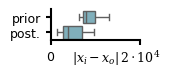

In [211]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(1.15,0.4))
    sns.boxplot(y='Set', x='Values', data=df, color="#76b5c5")
    plt.ylabel("")
    plt.xlim(0, 20_000)
    plt.xticks([0,20_000],["0", r"$2\cdot 10^4$"])
    #plt.xscale("log")
    plt.xlabel("$|x_i - x_o|$", labelpad=-12)
    fig.savefig("posterior_predictive_metric_100.svg", transparent=True)